# Q2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Load the Oxford-IIIT Pet dataset
dataset_name = "oxford_iiit_pet"
(ds_train_val, ds_test), ds_info = tfds.load(
    name=dataset_name,
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# Define the size of the dataset
total_train_samples = ds_info.splits['train'].num_examples
total_test_samples = ds_info.splits['test'].num_examples

 # Reserve 20% for validation from total_train_samples
train_size = int(0.8 * total_train_samples)
val_size = int(0.2 * total_train_samples)

# Split the dataset into train, validation
ds_train = ds_train_val.take(train_size)
ds_val = ds_train_val.skip(train_size).take(val_size)

print(f"Number of training samples: {ds_train.cardinality()}")
print(f"Number of validation samples: {ds_val.cardinality()}")
print(f"Number of test samples: {ds_test.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3XES9K/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3XES9K/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


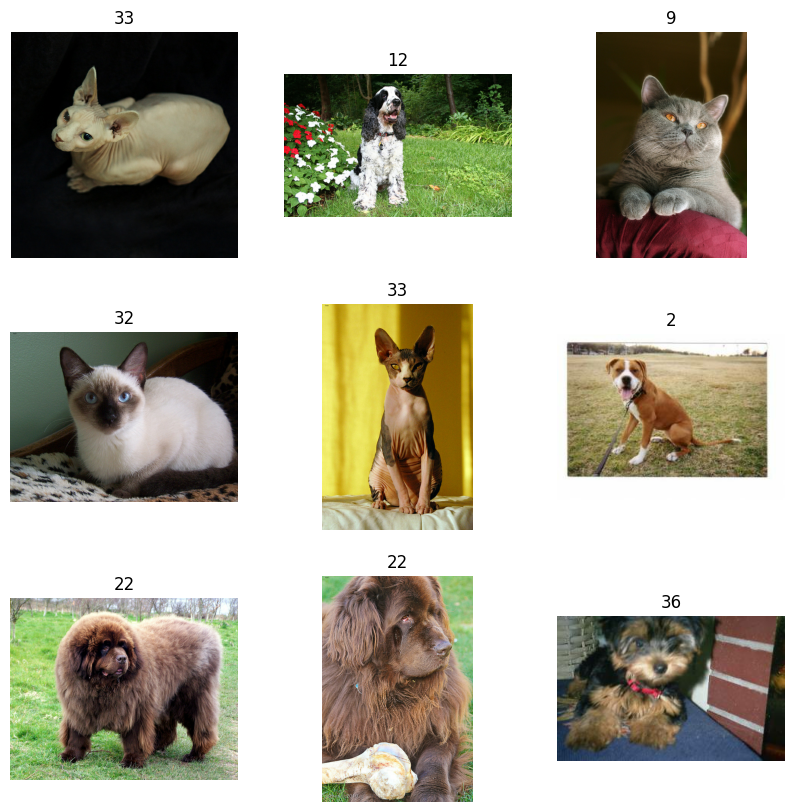

In [ ]:
#plot first 9 images in the training dataset with labels
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
#resize images to 150x150
resize_fn = tf.keras.layers.Resizing(150, 150)
ds_train = ds_train.map(lambda x, y: (resize_fn(x), y))
ds_val = ds_val.map(lambda x, y: (resize_fn(x), y))
ds_test = ds_test.map(lambda x, y: (resize_fn(x), y))

In [ ]:
#Using random data augmentation
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]
def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x
ds_train = ds_train.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
from tensorflow import data as tf_data
batch_size = 64
ds_train = ds_train.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
ds_val = ds_val.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
ds_test = ds_test.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

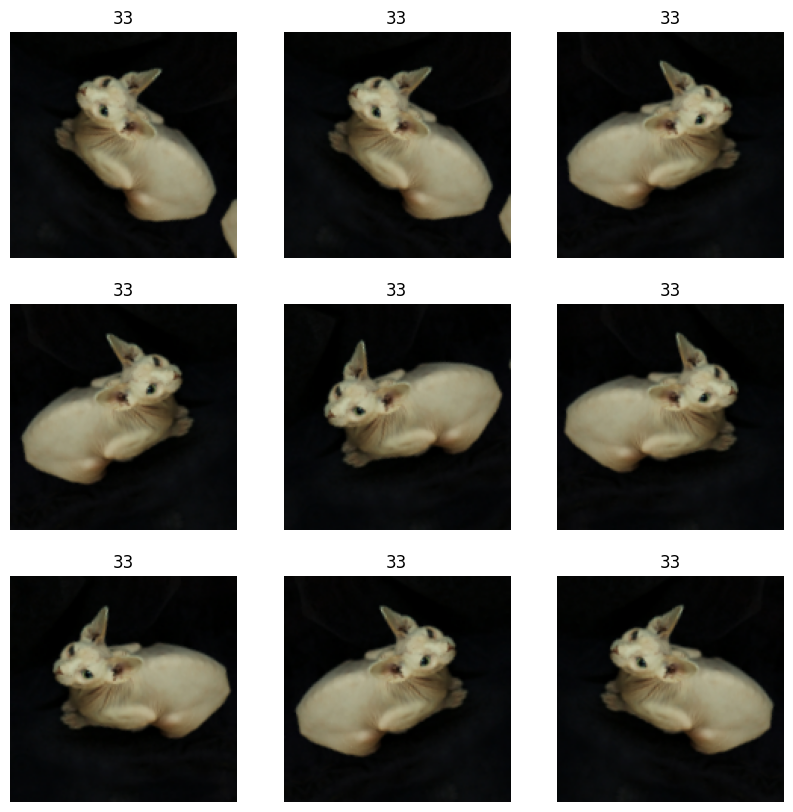

In [ ]:
import numpy as np
for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = tf.keras.applications.DenseNet201(
    weights="imagenet",  # Load pre-trained weights on ImageNet dataset.   # InceptionResNetV2(82) , NASNetLarge (83.40), DenseNet121 (83.78)
    input_shape=(150, 150, 3),
    include_top=False, #  Classifier at the top is not considered.
)
base_model.trainable = False # Freeze the base_model, not training

# Creating new model
inputs = tf.keras.Input(shape=(150, 150, 3))
#rescale the input
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1) # Xception weights requires that input be scaled from (0, 255) to a range of (-1., +1.)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # use dropout for reguralization
outputs = tf.keras.layers.Dense(37, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

74836368/74836368 [==============================] - 1s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 densenet201 (Functional)    (None, 4, 4, 1920)        1832198   N          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 1920)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

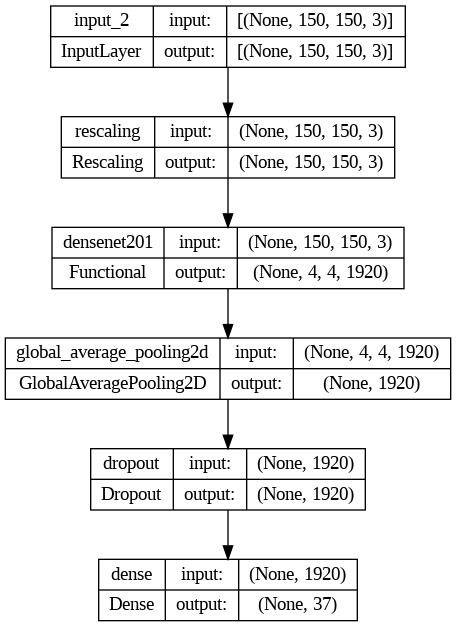

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
loss0, accuracy0 = model.evaluate(ds_val)
print("Initial Loss: {:.2f}".format(loss0))
print(f'Initial Accuracy: {accuracy0 * 100:.2f}%')

12/12 [==============================] - 36s 420ms/step - loss: 5.1787 - accuracy: 0.0149
Initial Loss: 5.18
Initial Accuracy: 1.49%


In [ ]:
# Train the model
initial_epochs = 30
history = model.fit(ds_train, epochs=initial_epochs,  validation_data=ds_val )

Epoch 1/30
46/46 [==============================] - 34s 438ms/step - loss: 2.4016 - accuracy: 0.3798 - val_loss: 0.8086 - val_accuracy: 0.7473
Epoch 2/30
46/46 [==============================] - 8s 167ms/step - loss: 0.8522 - accuracy: 0.7351 - val_loss: 0.5700 - val_accuracy: 0.8152
Epoch 3/30
46/46 [==============================] - 8s 172ms/step - loss: 0.5840 - accuracy: 0.8145 - val_loss: 0.4946 - val_accuracy: 0.8315
Epoch 4/30
46/46 [==============================] - 9s 192ms/step - loss: 0.4476 - accuracy: 0.8485 - val_loss: 0.4538 - val_accuracy: 0.8533
Epoch 5/30
46/46 [==============================] - 8s 169ms/step - loss: 0.3308 - accuracy: 0.9069 - val_loss: 0.4248 - val_accuracy: 0.8573
Epoch 6/30
46/46 [==============================] - 8s 173ms/step - loss: 0.2851 - accuracy: 0.9062 - val_loss: 0.4301 - val_accuracy: 0.8655
Epoch 7/30
46/46 [==============================] - 8s 169ms/step - loss: 0.2290 - accuracy: 0.9324 - val_loss: 0.4005 - val_accuracy: 0.8818
Epoch

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#continue training further if needed
add_epochs = 10
tot_epochs = initial_epochs + add_epochs
history1 = model.fit(
    ds_train,
    epochs=tot_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=ds_val
)

acc += history1.history['accuracy']
val_acc += history1.history['val_accuracy']

loss += history1.history['loss']
val_loss += history1.history['val_loss']

Epoch 30/40
46/46 [==============================] - 8s 176ms/step - loss: 0.0292 - accuracy: 0.9956 - val_loss: 0.4240 - val_accuracy: 0.8696
Epoch 31/40
46/46 [==============================] - 8s 177ms/step - loss: 0.0305 - accuracy: 0.9969 - val_loss: 0.4365 - val_accuracy: 0.8723
Epoch 32/40
46/46 [==============================] - 8s 174ms/step - loss: 0.0351 - accuracy: 0.9925 - val_loss: 0.4199 - val_accuracy: 0.8709
Epoch 33/40
46/46 [==============================] - 8s 178ms/step - loss: 0.0293 - accuracy: 0.9969 - val_loss: 0.4441 - val_accuracy: 0.8668
Epoch 34/40
46/46 [==============================] - 9s 201ms/step - loss: 0.0306 - accuracy: 0.9952 - val_loss: 0.4271 - val_accuracy: 0.8655
Epoch 35/40
46/46 [==============================] - 8s 174ms/step - loss: 0.0242 - accuracy: 0.9966 - val_loss: 0.4154 - val_accuracy: 0.8804
Epoch 36/40
46/46 [==============================] - 8s 177ms/step - loss: 0.0252 - accuracy: 0.9969 - val_loss: 0.4237 - val_accuracy: 0.8818

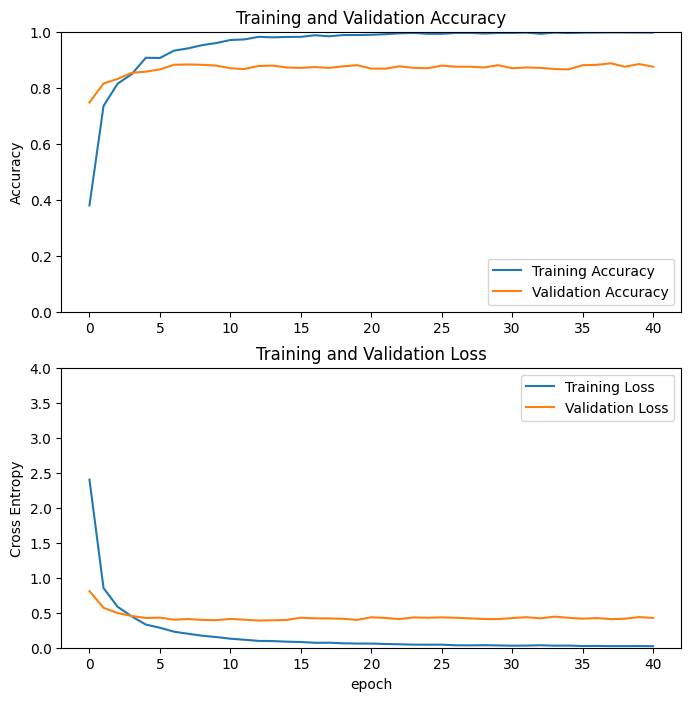

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

58/58 [==============================] - 16s 272ms/step - loss: 0.5018 - accuracy: 0.8591
Test Accuracy: 85.91%
